<a href="https://colab.research.google.com/github/Wanlu-koeln/vision_model/blob/main/Copy_of_ResNet_oPE_wrapper_w_pw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision.models import resnet18
from torch import nn, save, max, no_grad, randperm
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from google.colab import drive
from numpy import mean
import pandas as pd
import sys
import os

Mounted at /content/drive


In [ ]:
foder_path = os.path.abspath('/Users/wanlufu/Desktop/vision_model')
sys.path.append(folder_path)

In [ ]:
#!unzip /content/drive/MyDrive/ColabNotebooks/images_for_vision_recognition_models_w_vs_pw_large.zip -d /content/drive/MyDrive/ColabNotebooks/

In [ ]:
def load_train_data(folder = "normal", N_train_samples = 100):
  transform = transforms.Compose([
      transforms.Grayscale(),
      transforms.ToTensor(), 
      transforms.Normalize((0.5,), (0.5,)) 
    ])
  train_ds = ImageFolder(root = '/Users/wanlufu/Desktop/vision_model/images_for_vision_recognition_models_w_vs_pw_large/'+folder+'/train', transform=transform)
  subsample_train_indices = randperm(len(train_ds))[:N_train_samples]
  train_dl = DataLoader(train_ds, batch_size=64, sampler=SubsetRandomSampler(subsample_train_indices))
  return train_dl

def load_test_data(folder = "normal"):
  transform = transforms.Compose([
      transforms.Grayscale(),
      transforms.ToTensor(), 
      transforms.Normalize((0.5,), (0.5,)) 
    ])
  test_ds = ImageFolder(root='/Users/wanlufu/Desktop/vision_model/images_for_vision_recognition_models_w_vs_pw_large/'+folder+'/test', transform=transform)
  test_dl = DataLoader(test_ds, batch_size=64)
  return test_ds

def fit_test_model(folder = "normal", N_train_samples = 100):
  
  train_dl = load_train_data(folder = folder, N_train_samples = N_train_samples)
  test_dl = load_train_data(folder = folder)
  
  model = resnet18(num_classes=2) 
  model.conv1 = nn.Conv2d(1, 64, kernel_size=(63, 63), stride=(2, 2), padding=1, bias=False)

  # Define the optimizer and loss function
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  #print(train_dl)
  for _ in range(17):
      for inputs, labels in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
  total = 0
  correct = 0
  model.eval()
  with no_grad(): # This is optional but saves memory
    for inputs, labels in test_dl:
        # Forward pass
        outputs = model(inputs)
        # Calculate predictions
        _, predicted = max(outputs, 1)
        # Calculate accuracy (optional)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  return (correct / total)

In [ ]:
def wrapper_model_fit(folder_list = ["40p","80p"], N_train_samples_list = [1240, 2479, 3719, 4958], iterations = 10):
  data = []

  for folder in folder_list:
    for N_train_samples in N_train_samples_list:
      print(str(N_train_samples)+" "+folder)
      acc_list = [fit_test_model(folder = folder, N_train_samples = N_train_samples) for i in range(iterations)]
      print(mean(acc_list))
      [data.append({'folder': folder, 'train_samples': N_train_samples, 'acc': acc}) for acc in acc_list]

  return data

In [ ]:
 N = 11500
#[round(N*.1), round(N*.25), round(N*.5), round(N*.75), round(N*1)]
data = wrapper_model_fit(folder_list = ["50p","normal"], N_train_samples_list = [round(N)], iterations = 5)
df = pd.DataFrame.from_records(data)
df

11500 50p


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


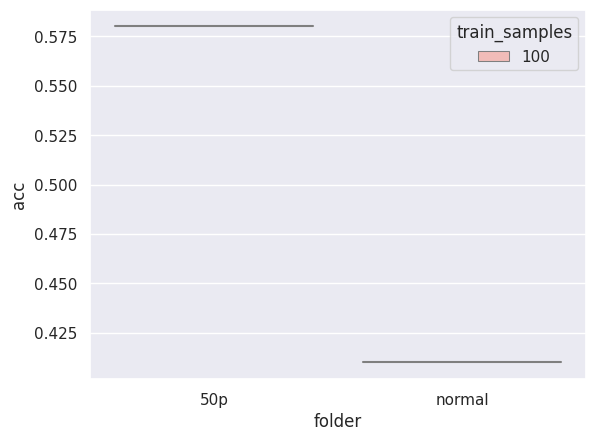

In [ ]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid") 
# Grouped violinplot
sns.violinplot(x="folder", y="acc", hue="train_samples", data=df, palette="Pastel1")
plt.show()